In [103]:
import pandas as pd
import matplotlib.pyplot as plt

from mlforecast import MLForecast
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

import sys
import os
sys.path.append(os.path.abspath("../"))

from scripts.evaluate import evaluate_forecasts
from scripts.visualization import *

In [82]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [83]:
df_brl = pd.read_parquet('../data/all_comm/comm_brl.parquet')
df_usd = pd.read_parquet('../data/all_comm/comm_usd.parquet')

In [84]:
Y_test_df_brl = df_brl.groupby('unique_id').tail(24)
remaining = df_brl.drop(Y_test_df_brl.index, axis = 0)
X_val_df_brl = remaining.groupby('unique_id').tail(12)
X_train_df_brl = remaining.drop(X_val_df_brl.index, axis=0)

In [85]:
X_train_df_brl.head()

,ds,y,unique_id
0,2003-05-01,28.156667,ACUCAR
1,2003-06-01,25.092000,ACUCAR
2,2003-07-01,23.928636,ACUCAR
3,2003-08-01,29.410000,ACUCAR
4,2003-09-01,24.313636,ACUCAR


In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()


# def prepare_data(df):
#     df_copy = df.copy()
#     # Agrupar por commodity para normalizar separadamente
#     for commodity in df_copy['unique_id'].unique():
#         mask = df_copy['unique_id'] == commodity
#         df_copy.loc[mask, 'y'] = scaler.fit_transform(df_copy.loc[mask, 'y'].values.reshape(-1, 1))
#     return df_copy


# X_train_df_brl = prepare_data(X_train_df_brl)
# X_val_df_brl = prepare_data(X_val_df_brl)
# Y_test_df_brl = prepare_data(Y_test_df_brl)

In [87]:
models = [
    LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    KNeighborsRegressor(
        n_neighbors=5,
        weights='distance'
    ),
    MLPRegressor(
        hidden_layer_sizes=(50, 25),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=3,
        random_state=42
    )
]

fcst = MLForecast(
    models=models,
    freq='ME',
    lags=[1, 2, 3, 4, 5, 6],
    date_features=['month', 'year'],
    num_threads=4
)

In [88]:
fcst.fit(
    df=X_train_df_brl,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 1214, number of used features: 8
[LightGBM] [Info] Start training from score 159.509398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

MLForecast(models=[LGBMRegressor, XGBRegressor, KNeighborsRegressor, MLPRegressor, RandomForestRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6'], date_features=['month', 'year'], num_threads=4)

In [ ]:
forecasts_val = fcst.predict(h=12)

In [ ]:
full_train = pd.concat([X_train_df_brl, X_val_df_brl])
fcst.fit(full_train)  
forecasts_test = fcst.predict(h=24)
forecasts_test = forecasts_test.reset_index()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 1274, number of used features: 8
[LightGBM] [Info] Start training from score 172.863178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [100]:
forecasts_test.head()

,index,unique_id,ds,LGBMRegressor,XGBRegressor,KNeighborsRegressor,MLPRegressor,RandomForestRegressor
0,0,ACUCAR,2023-02-28,132.635096,131.180786,132.388816,141.164237,97.792037
1,1,ACUCAR,2023-03-31,131.006275,128.624619,132.344383,144.080355,97.792037
2,2,ACUCAR,2023-04-30,130.894754,128.624619,129.946165,149.270784,97.792037
3,3,ACUCAR,2023-05-31,130.894754,128.624619,128.269641,156.470614,97.792037
4,4,ACUCAR,2023-06-30,130.461783,128.476685,129.964344,161.533487,97.792037


In [104]:
metrics_df = pd.DataFrame()

for commodity in Y_test_df_brl['unique_id'].unique():
    actual = Y_test_df_brl[Y_test_df_brl['unique_id'] == commodity]['y']
    
    for model in ['LGBMRegressor', 'XGBRegressor', 'KNeighborsRegressor', 'MLPRegressor', 'RandomForestRegressor']:
        pred = forecasts_test[forecasts_test['unique_id'] == commodity][model]
        metrics = evaluate_forecasts(actual, pred)
        
        temp_df = pd.DataFrame({
            'Commodity': [commodity],
            'Model': [model],
            'MAE': [metrics['MAE']],
            'MAPE': [metrics['MAPE']],
            'MSE': [metrics['MSE']],
            'RMSE': [metrics['RMSE']],
            'R2': [metrics['R2']]
        })
        
        metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)

metrics_df = metrics_df.round(4)

In [106]:
print("Métricas de Erro por Commodity e Modelo:")
metrics_df

Métricas de Erro por Commodity e Modelo:


,Commodity,Model,MAE,MAPE,MSE,RMSE,R2
0,ACUCAR,LGBMRegressor,24.2148,0.1617,763.3644,27.6291,-7.7232
1,ACUCAR,XGBRegressor,20.2897,0.1355,512.5398,22.6393,-4.8570
2,ACUCAR,KNeighborsRegressor,14.3190,0.0948,284.3409,16.8624,-2.2493
3,ACUCAR,MLPRegressor,61.8587,0.4253,5543.2089,74.4527,-62.3440
4,ACUCAR,RandomForestRegressor,47.9973,0.3265,2391.2480,48.9004,-26.3256
5,ALGODAO,LGBMRegressor,112.7659,0.2817,13433.6940,115.9038,-31.7933
6,ALGODAO,XGBRegressor,109.2215,0.2728,12447.2836,111.5674,-29.3853
7,ALGODAO,KNeighborsRegressor,83.9885,0.2102,8563.7014,92.5403,-19.9050
8,ALGODAO,MLPRegressor,287.3514,0.7153,98943.4294,314.5527,-240.5331
9,ALGODAO,RandomForestRegressor,48.1613,0.1208,2543.2083,50.4302,-5.2083


In [107]:
print("\nMétricas Médias por Modelo:")
print(metrics_df.groupby('Model')[['MAE', 'RMSE', 'MAPE', 'R2']].mean().round(4))


Métricas Médias por Modelo:
                            MAE      RMSE    MAPE        R2
Model                                                      
KNeighborsRegressor    107.2386  134.0013  0.2638   -9.9759
LGBMRegressor          111.7461  139.3986  0.2545  -11.9462
MLPRegressor           179.6828  219.8247  0.6633 -111.6487
RandomForestRegressor  104.2696  140.0164  0.3078  -13.6693
XGBRegressor           108.9692  136.2417  0.2424  -10.5159


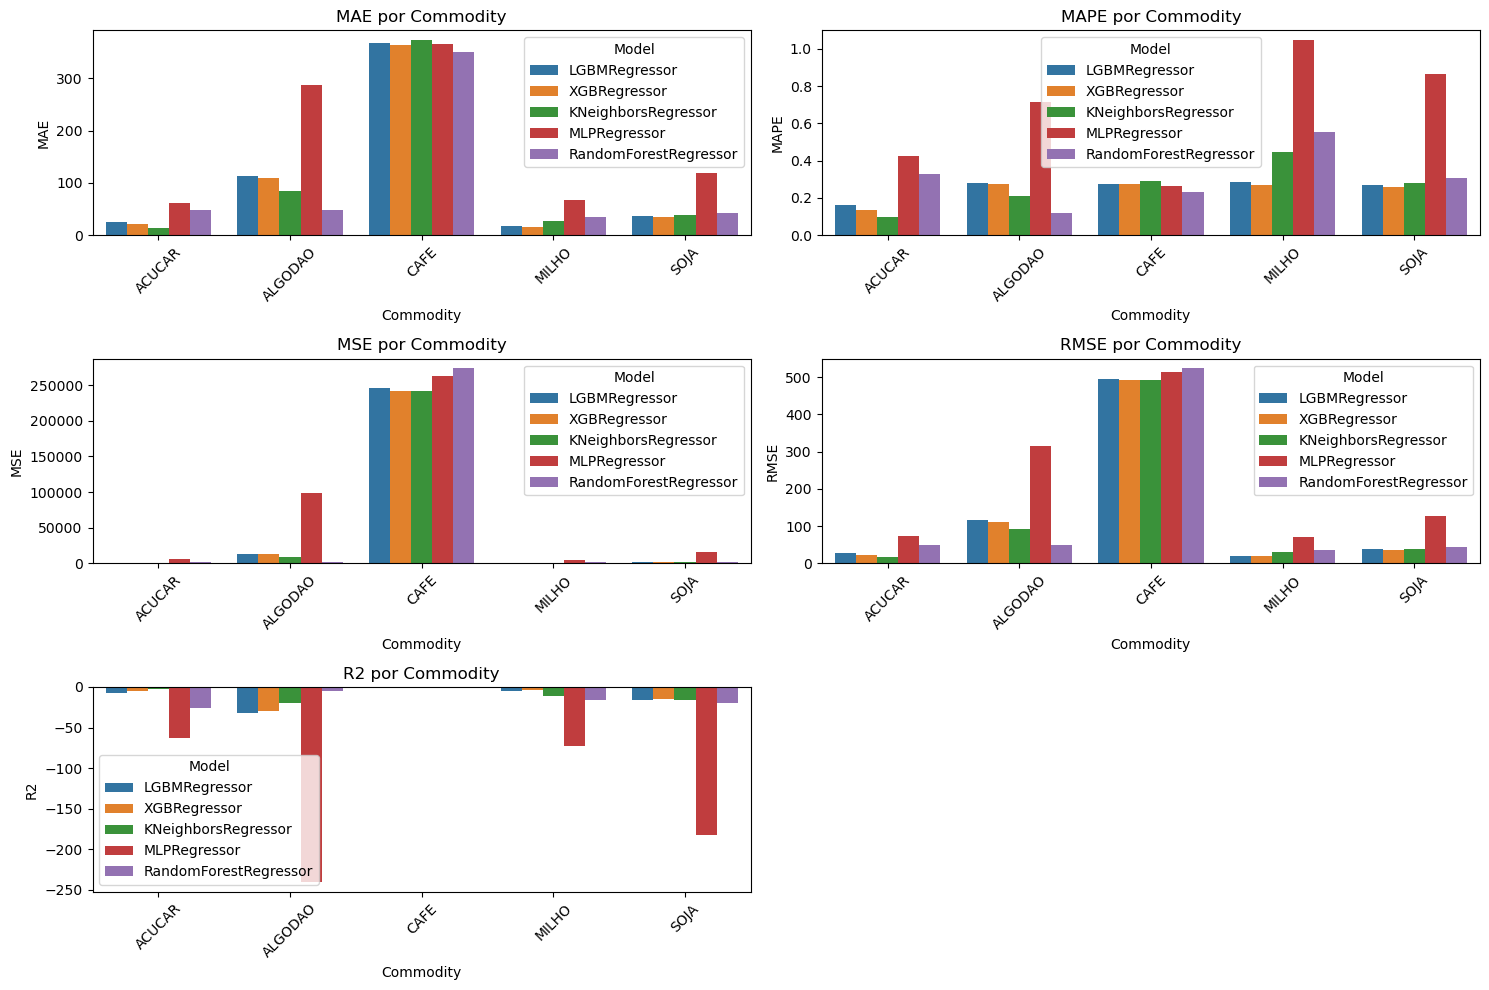

In [108]:
plot_metrics_comparison(metrics_df)

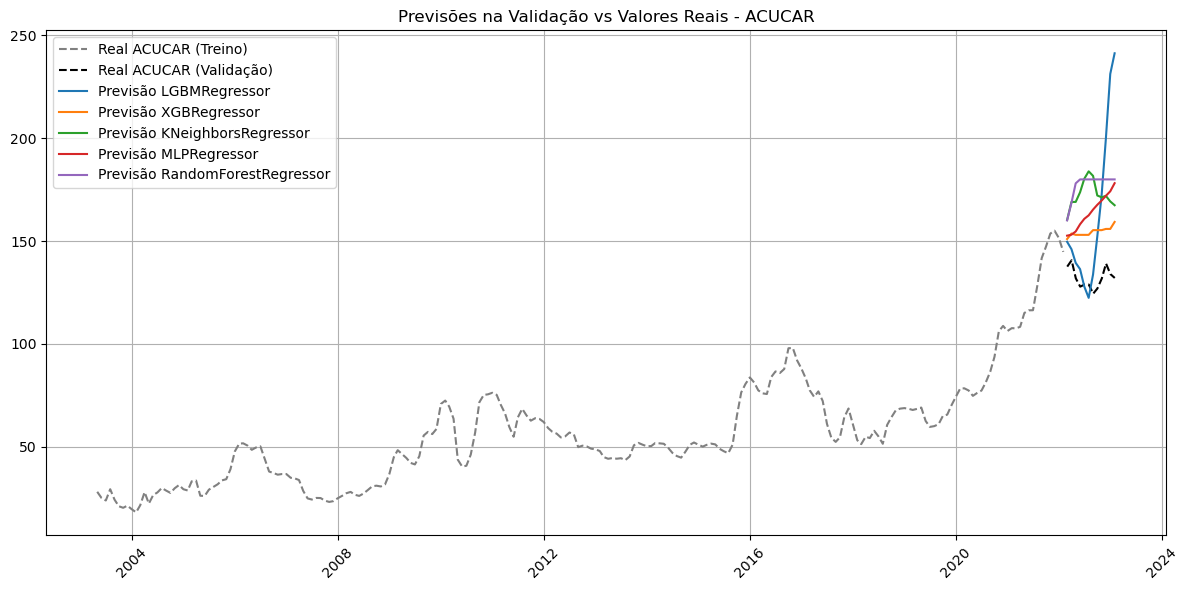

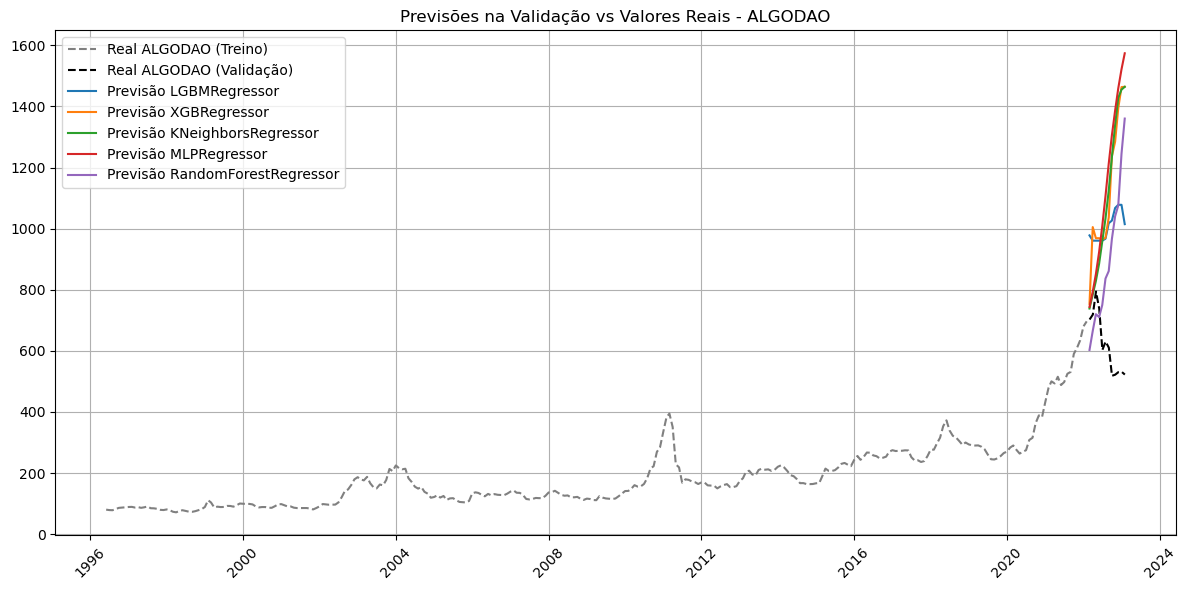

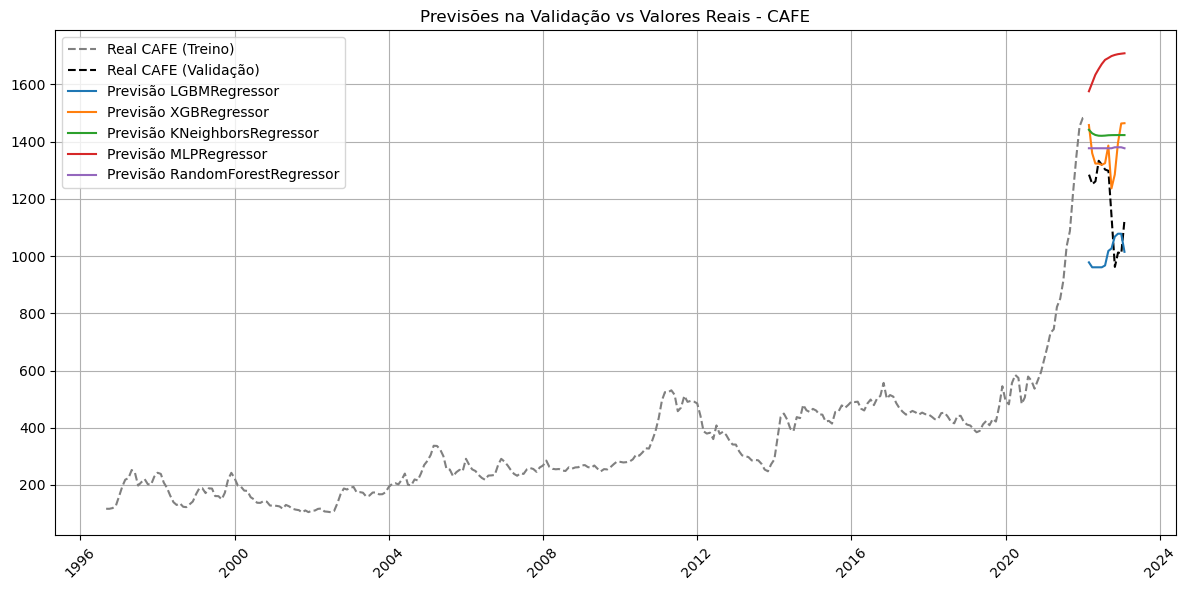

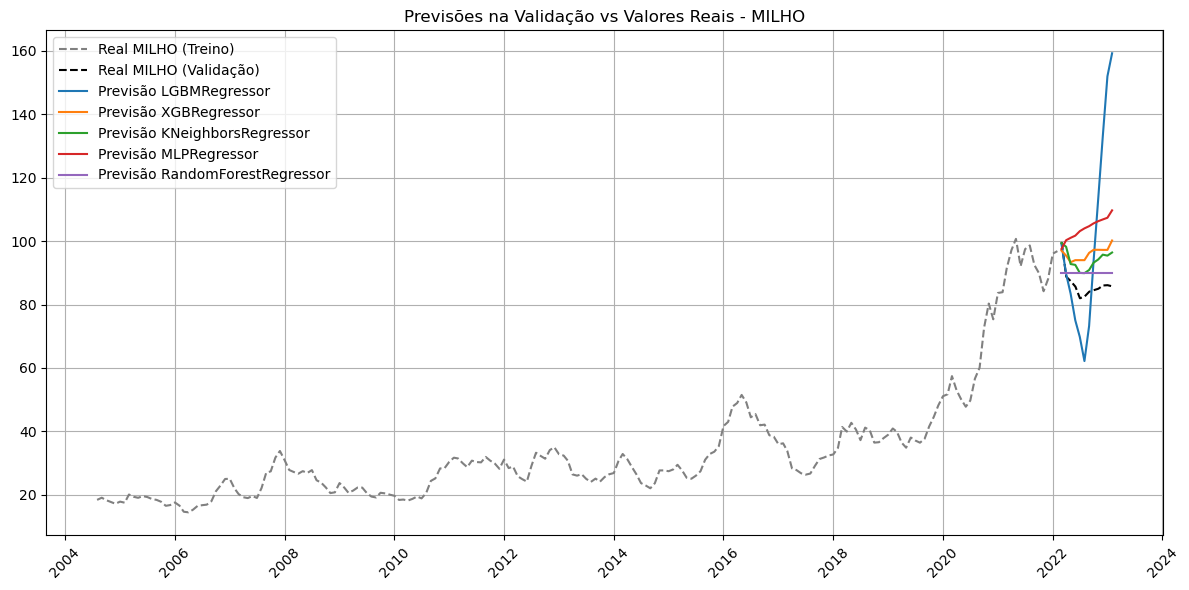

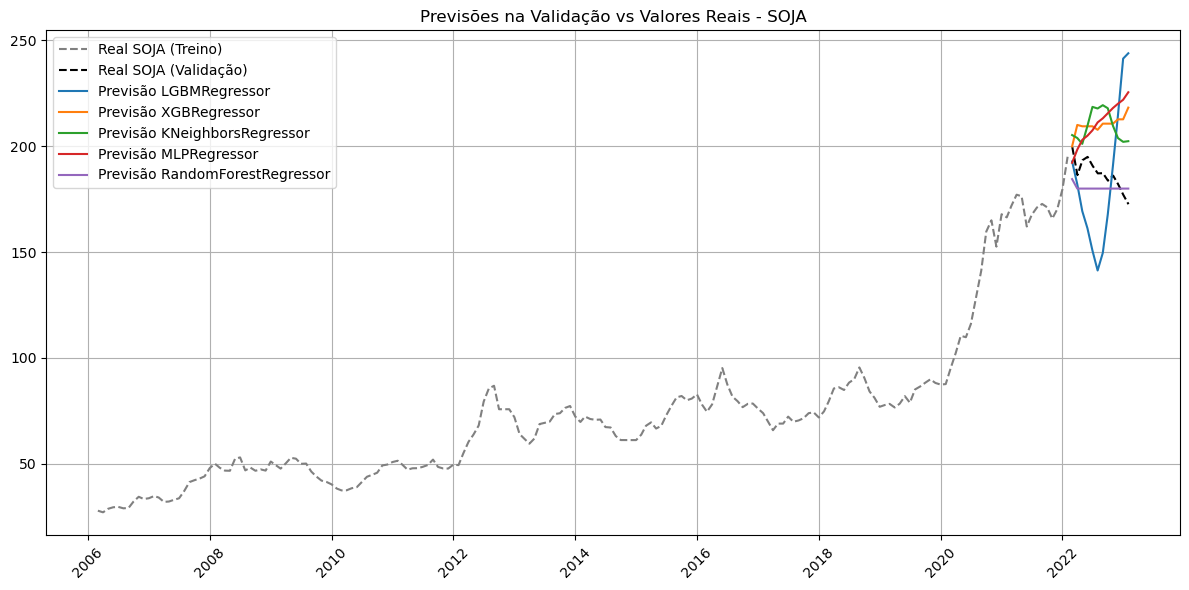

In [101]:
for commodity in X_val_df_brl['unique_id'].unique():
    plot_validation_forecasts(
        train_data=X_train_df_brl,
        val_data=X_val_df_brl,
        forecasts_val=forecasts_val,
        commodity=commodity,
        models=['LGBMRegressor', 'XGBRegressor', 'KNeighborsRegressor', 'MLPRegressor', 'RandomForestRegressor']
    )

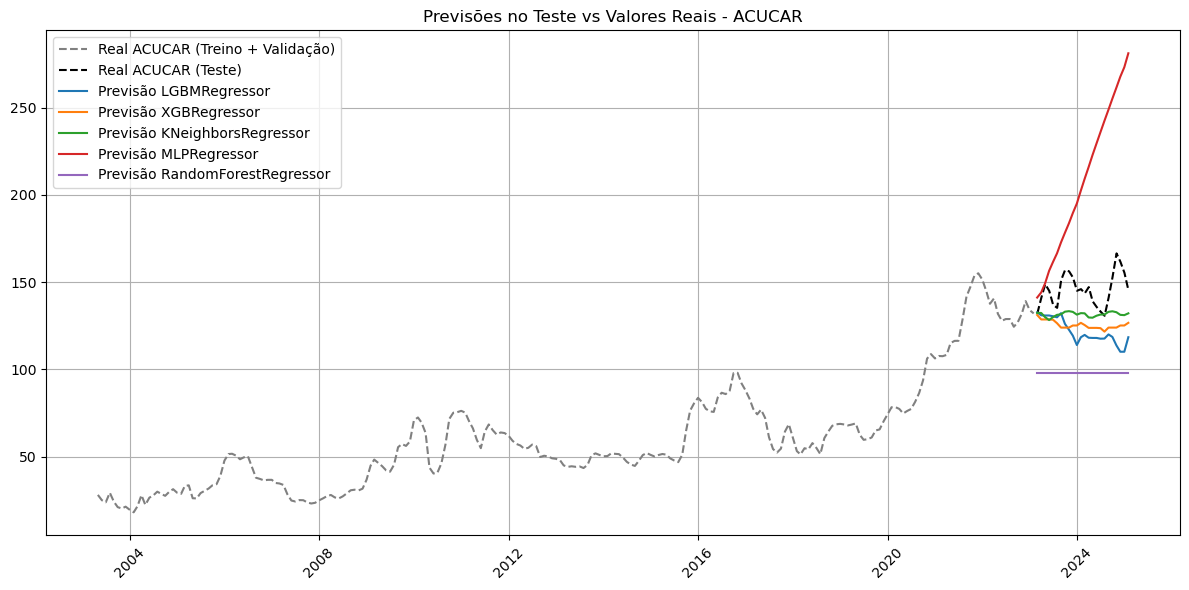

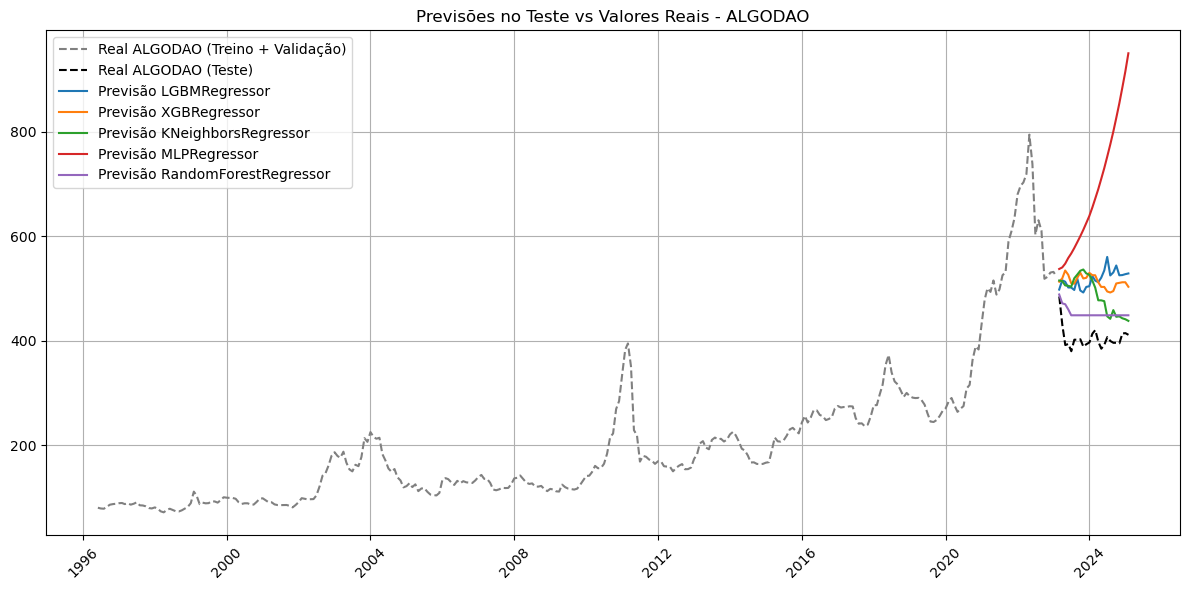

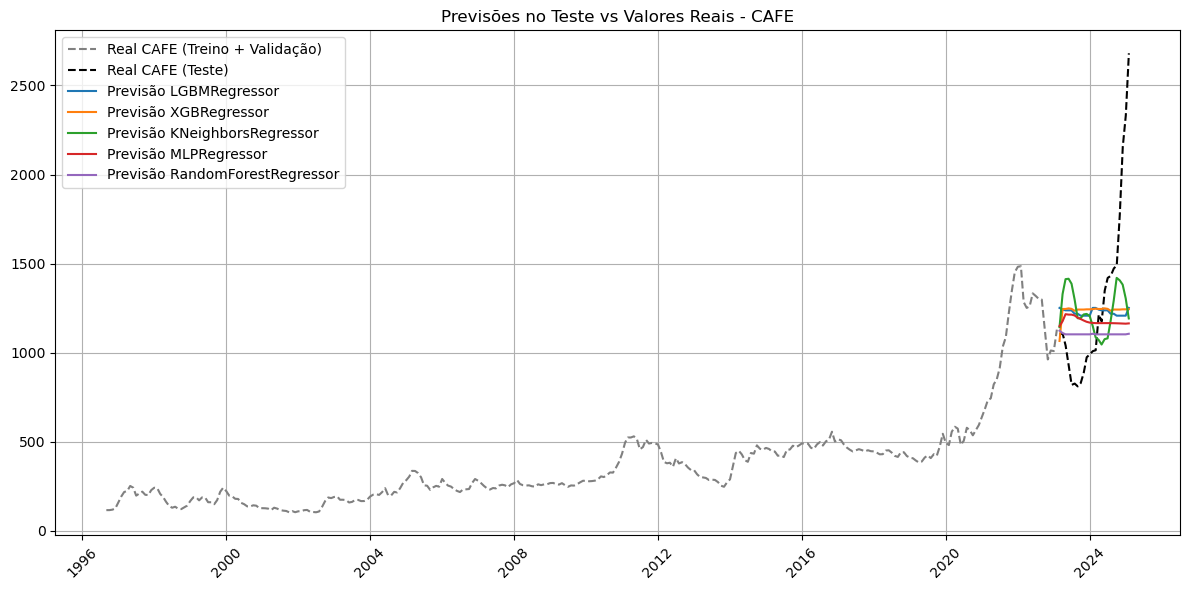

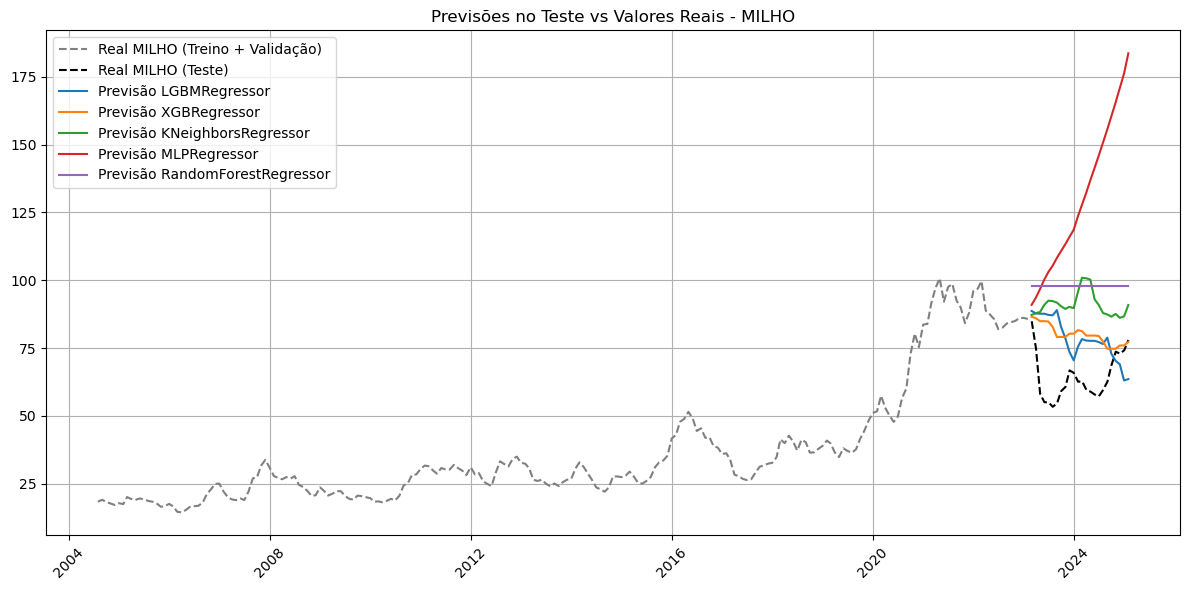

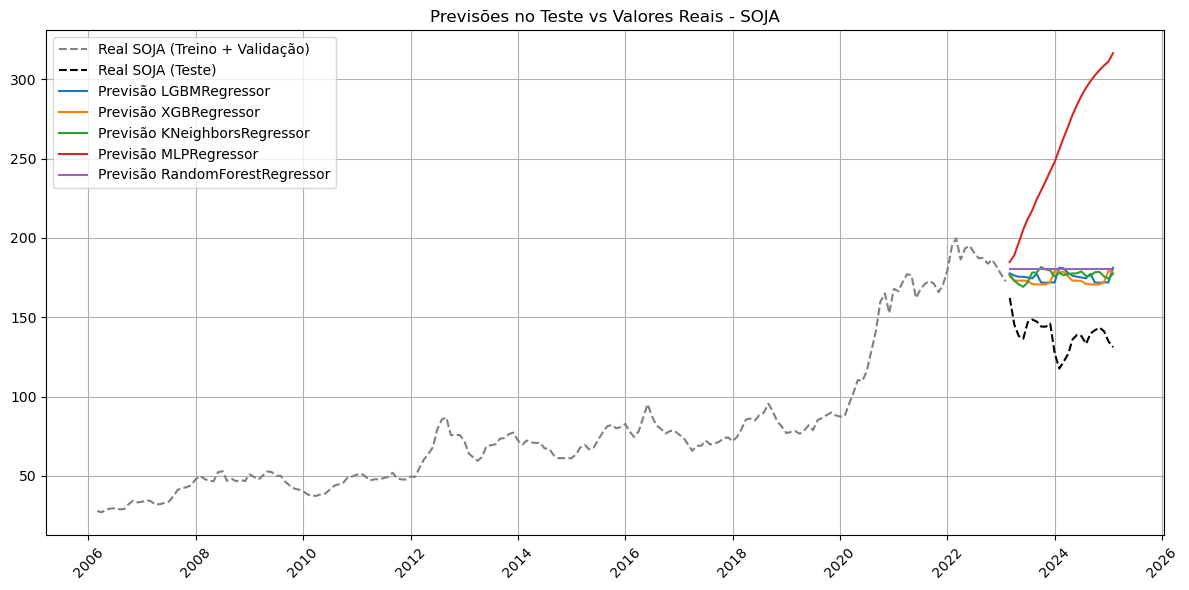

In [102]:
for commodity in Y_test_df_brl['unique_id'].unique():
    plot_test_forecasts(
        full_train=full_train,
        test_data=Y_test_df_brl,
        forecasts_test=forecasts_test,
        commodity=commodity,
        models=['LGBMRegressor', 'XGBRegressor', 'KNeighborsRegressor', 'MLPRegressor', 'RandomForestRegressor']
    )